In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.extra.model import ModelDistribution
from src.extra.pprint import print_model
from src.core.core import reset_model

from src.greedy.greedy import greedy_algorithm
from src.greedy.resource_allocation_policy import SumPercentage
from src.greedy.server_selection_policy import SumResources
from src.greedy.task_prioritisation import UtilityDeadlinePerResource

from src.optimal.fixed_optimal import fixed_optimal
from src.core.fixed_task import FixedTask, SumSpeedPowFixedAllocationPriority

In [3]:
def print_results(result, tasks, servers):
    print(f'Social welfare: {result.social_welfare:.3f}, Percentage social welfare: {result.percentage_social_welfare:.3f}, Percentage tasks: {result.percentage_tasks_allocated:.3f}\n')
    # for server in servers:
    #    storage_usage = sum(task.required_storage for task in server.allocated_tasks) / server.storage_capacity
    #    computational_usage = sum(task.compute_speed for task in server.allocated_tasks) / server.computation_capacity
    #    bandwidth_usage = sum(task.loading_speed + task.sending_speed for task in server.allocated_tasks) / server.bandwidth_capacity
    #    print(f'{server.name} resouce usage - Stor: {storage_usage:.3f}, Comp: {computational_usage:.3f}, Band: {bandwidth_usage:.3f}')
    print(f'Server avg storage: {np.mean([sum(task.required_storage for task in server.allocated_tasks) / server.storage_capacity for server in servers]):3.2f}, '
          f'computation: {np.mean([sum(task.compute_speed for task in server.allocated_tasks) / server.computation_capacity for server in servers]):3.2f}, '
          f'bandwidth: {np.mean([sum(task.loading_speed + task.sending_speed for task in server.allocated_tasks) / server.bandwidth_capacity for server in servers]):3.2f}')
    
    avg_loading_speed = np.mean([task.loading_speed for task in tasks if task.running_server])
    avg_compute_speed = np.mean([task.compute_speed for task in tasks if task.running_server])
    avg_sending_speed = np.mean([task.sending_speed for task in tasks if task.running_server])
    print(f'\nTask avg loading speed: {avg_loading_speed:3.2f}, compute speed: {avg_compute_speed:3.2f}, sending speed: {avg_sending_speed:3.2f}')
    avg_loading_time = np.mean([task.required_storage / task.loading_speed for task in tasks if task.running_server])
    avg_compute_time = np.mean([task.required_computation / task.compute_speed for task in tasks if task.running_server])
    avg_sending_time = np.mean([task.required_results_data / task.sending_speed for task in tasks if task.running_server])
    print(f'Task avg loading time: {avg_loading_time:3.2f}, compute time: {avg_compute_time:3.2f}, sending time: {avg_sending_time:3.2f}')
    

def avg_resource(tasks, attribute):
    return np.mean([getattr(task, attribute) for task in tasks])

In [4]:
alibaba_model = ModelDistribution('../realistic.mdl', num_tasks=50, num_servers=10)
alibaba_model.storage_scaling = 500
alibaba_model.computational_scaling = 1
alibaba_model.results_data_scaling = 5

Tasks - required_storage: 57.26, required_computation: 992.30, required_results_data: 19.34

Fixed tasks - required_storage: 144.40, required_computation: 3456.00, required_results_data: 19.34
Fixed tasks - loading_speed: 36.68, compute_speed: 70.00, sending_speed: 9.88

Foreknowledge fixed tasks - required_storage: 57.26, required_computation: 992.30, required_results_data: 19.34
Foreknowledge fixed tasks - loading_speed: 12.76, compute_speed: 24.50, sending_speed: 9.88


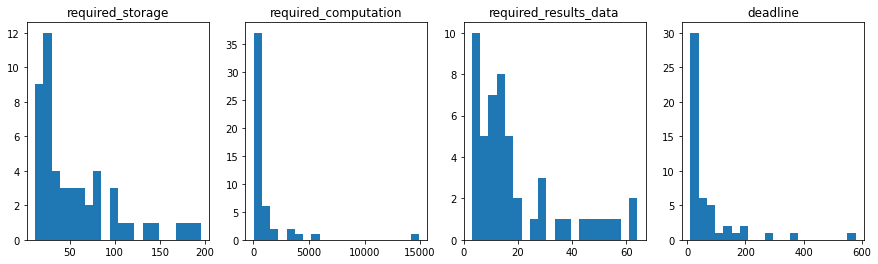

In [5]:
tasks, servers = alibaba_model.generate()
print('Tasks - ' + ', '.join([f"{var}: {avg_resource(tasks, var):3.2f}" for var in ["required_storage", "required_computation", "required_results_data"]]))

fixed_tasks = [FixedTask(task, SumSpeedPowFixedAllocationPriority()) for task in tasks]
print('\nFixed tasks - ' + ', '.join([f"{var}: {avg_resource(fixed_tasks, var):3.2f}" for var in ["required_storage", "required_computation", "required_results_data"]]))
print('Fixed tasks - ' + ', '.join([f"{var}: {avg_resource(fixed_tasks, var):3.2f}" for var in ["loading_speed", "compute_speed", "sending_speed"]]))

foreknowledge_fixed_tasks = [FixedTask(task, SumSpeedPowFixedAllocationPriority(), resource_foreknowledge=True) for task in tasks]
print('\nForeknowledge fixed tasks - ' + ', '.join([f"{var}: {avg_resource(foreknowledge_fixed_tasks, var):3.2f}" for var in ["required_storage", "required_computation", "required_results_data"]]))
print('Foreknowledge fixed tasks - ' + ', '.join([f"{var}: {avg_resource(foreknowledge_fixed_tasks, var):3.2f}" for var in ["loading_speed", "compute_speed", "sending_speed"]]))

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for ax, var in zip(axs.flatten(), ['required_storage', 'required_computation', 'required_results_data', 'deadline']):
    ax.hist([getattr(task, var) for task in tasks], bins=20)
    ax.set_title(var)

In [6]:
result = greedy_algorithm(tasks, servers, UtilityDeadlinePerResource(), SumResources(), SumPercentage())
print_results(result, tasks, servers)

Social welfare: 538.130, Percentage social welfare: 0.989, Percentage tasks: 0.940

Server avg storage: 0.73, computation: 0.84, bandwidth: 0.90

Task avg loading speed: 6.17, compute speed: 28.91, sending speed: 3.38
Task avg loading time: 12.98, compute time: 46.52, sending time: 7.09


In [7]:
reset_model(tasks, servers)
result = fixed_optimal(fixed_tasks, servers, time_limit=4)
print_results(result, fixed_tasks, servers)

Social welfare: 317.570, Percentage social welfare: 0.583, Percentage tasks: 0.460

Server avg storage: 0.75, computation: 0.89, bandwidth: 0.98

Task avg loading speed: 16.61, compute speed: 60.87, sending speed: 4.70
Task avg loading time: 11.48, compute time: 74.00, sending time: 4.69


In [8]:
reset_model(tasks, servers)
result = fixed_optimal(foreknowledge_fixed_tasks, servers, time_limit=4)
print_results(result, foreknowledge_fixed_tasks, servers)

Social welfare: 425.840, Percentage social welfare: 0.782, Percentage tasks: 0.740

Server avg storage: 0.51, computation: 0.32, bandwidth: 0.99

Task avg loading speed: 7.54, compute speed: 12.03, sending speed: 5.86
Task avg loading time: 9.87, compute time: 60.64, sending time: 4.02
